# [Plant Seedlings Classification](https://www.kaggle.com/competitions/plant-seedlings-classification/code)


In [2]:
from copy import deepcopy
from datetime import datetime
from os import cpu_count, listdir, path
from pathlib import Path
from random import choice, seed
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import timm
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Subset
from torchsummary import summary
from torchviz import make_dot
from tqdm import tqdm

## Global Variables


In [3]:
# Metal Performance Shaders (MPS) - Apple Metal GPU acceleration
def get_mps_device() -> torch.device:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        x = torch.ones(1, device=device)
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        x = torch.ones(1, device=device)
    else:
        device = torch.device("cpu")
    return device


DEVICE = get_mps_device()

DATA_ROOT = Path("./data")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"

RANDOM_SEED = 42
BATCH_SIZE = 64

print(f"Torch version: {torch.__version__}")
print(f"CPU cores: {cpu_count()}")

print(f"DEVICE: {DEVICE}")
print(f"DATA_ROOT: {DATA_ROOT}")
print("Random seed:", RANDOM_SEED)
print("Batch size:", BATCH_SIZE)

print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

Torch version: 2.5.1
CPU cores: 8
DEVICE: mps
DATA_ROOT: data
Random seed: 42
Batch size: 64
MPS available: True
MPS built: True


## Reproducibility


In [4]:
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Loading


In [5]:
transform_resize = (224, 224)

transform = transforms.Compose(
    [
        transforms.Resize(transform_resize),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

total_sum = torch.zeros(3)
total_squared_sum = torch.zeros(3)
num_pixels = 0

for images, _ in loader:
    images: Tensor

    total_sum += images.sum(dim=[0, 2, 3])
    total_squared_sum += (images**2).sum(dim=[0, 2, 3])
    num_pixels += images.size(0) * images.size(2) * images.size(3)

transform_mean = total_sum / num_pixels
transform_std = torch.sqrt((total_squared_sum / num_pixels) - (transform_mean**2))

print("Mean:", transform_mean)
print("Std:", transform_std)

Mean: tensor([0.3288, 0.2894, 0.2073])
Std: tensor([0.1039, 0.1093, 0.1266])


In [6]:
transform = transforms.Compose(
    [
        transforms.Resize(size=transform_resize),
        transforms.RandomResizedCrop(
            size=transform_resize, scale=(0.8, 1.0), ratio=(0.9, 1.1)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=360),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=transform_mean, std=transform_std),
    ]
)

dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

len_dataset = len(dataset)
num_classes = len(dataset.classes)
print(f"Dataset length: {len_dataset}")
print(f"Dataset classes ({num_classes}): {dataset.classes}")

Dataset length: 4750
Dataset classes (12): ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Class Distribution


In [7]:
label_counts = {}
for label in listdir(TRAIN_DIR):
    label_path = path.join(TRAIN_DIR, label)

    if path.isdir(label_path):
        num_files = len(
            [f for f in listdir(label_path) if path.isfile(path.join(label_path, f))]
        )
        label_counts[label] = num_files

fig = px.bar(
    x=list(label_counts.keys()),
    y=list(label_counts.values()),
    title="Class Distribution",
    labels={"x": "Class", "y": "Count"},
).update_xaxes(categoryorder="total descending")
fig.show()

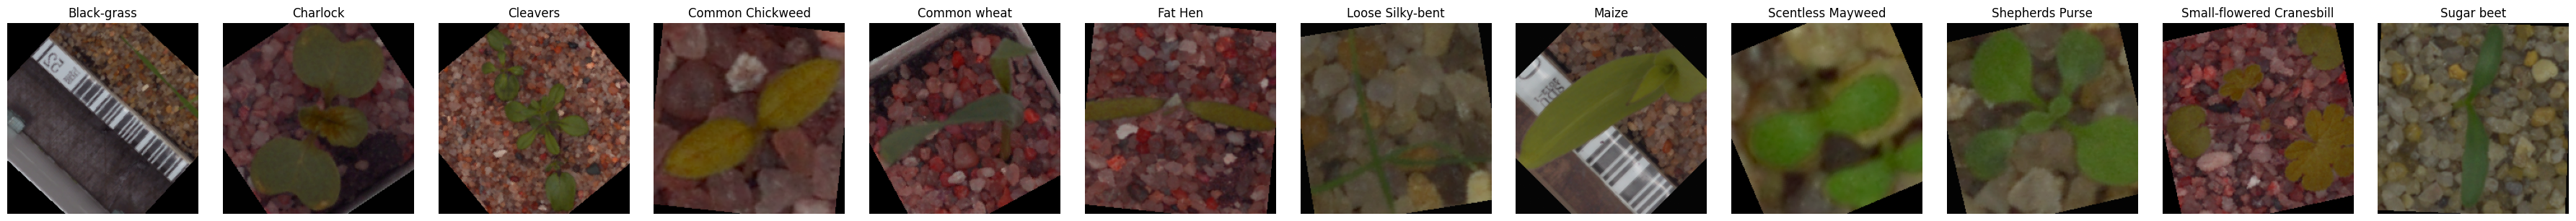

In [8]:
class_to_indices: Dict[int, List[int]] = {}
for i, (_, label) in enumerate(dataset.samples):
    if label not in class_to_indices:
        class_to_indices[label] = []
    class_to_indices[label].append(i)

fig: Figure
axs: List[Axes]
fig, axs = plt.subplots(1, num_classes, figsize=(3 * num_classes, 3))

for class_idx, ax in zip(range(num_classes), axs):
    sample_idx = choice(class_to_indices[class_idx])

    img_tensor: Tensor
    lbl: int
    img_tensor, lbl = dataset[sample_idx]

    img_unnormalized: torch.Tensor = img_tensor * transform_std.view(
        3, 1, 1
    ) + transform_mean.view(3, 1, 1)

    # Convert from CxHxW to HxWxC
    img_np = img_unnormalized.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(dataset.classes[class_idx])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Splitting Data


In [9]:
LEN_VALD = 0.2

labels = [label for _, label in dataset.samples]
train_indices, val_indices = train_test_split(
    range(len(dataset)), test_size=LEN_VALD, stratify=labels, random_state=RANDOM_SEED
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

Train dataset length: 3800
Validation dataset length: 950


In [10]:
fig = px.histogram(
    x=["Train"] * len(train_dataset) + ["Validation"] * len(val_dataset),
    title="Train and Validation Datasets",
    labels={"x": "Dataset", "y": "Count"},
)
fig.show()

## Model


In [11]:
print(timm.list_models("*vit*"))

['convit_base', 'convit_small', 'convit_tiny', 'crossvit_9_240', 'crossvit_9_dagger_240', 'crossvit_15_240', 'crossvit_15_dagger_240', 'crossvit_15_dagger_408', 'crossvit_18_240', 'crossvit_18_dagger_240', 'crossvit_18_dagger_408', 'crossvit_base_240', 'crossvit_small_240', 'crossvit_tiny_240', 'davit_base', 'davit_base_fl', 'davit_giant', 'davit_huge', 'davit_huge_fl', 'davit_large', 'davit_small', 'davit_tiny', 'efficientvit_b0', 'efficientvit_b1', 'efficientvit_b2', 'efficientvit_b3', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_l3', 'efficientvit_m0', 'efficientvit_m1', 'efficientvit_m2', 'efficientvit_m3', 'efficientvit_m4', 'efficientvit_m5', 'fastvit_ma36', 'fastvit_mci0', 'fastvit_mci1', 'fastvit_mci2', 'fastvit_s12', 'fastvit_sa12', 'fastvit_sa24', 'fastvit_sa36', 'fastvit_t8', 'fastvit_t12', 'flexivit_base', 'flexivit_large', 'flexivit_small', 'gcvit_base', 'gcvit_small', 'gcvit_tiny', 'gcvit_xtiny', 'gcvit_xxtiny', 'levit_128', 'levit_128s', 'levit_192', 'levit_256', 

In [12]:
model: torch.nn.Module = timm.create_model(
    "vit_base_patch16_224", pretrained=True, num_classes=num_classes
)
model.head = torch.nn.Linear(model.head.in_features, num_classes)
model = model.to(DEVICE)

# Freeze all layers except head
for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [12]:
LR = 1e-3
NUM_EPOCHS = 100
PATIENCE = NUM_EPOCHS // 20

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=PATIENCE // 2,
)

best_model_wts = deepcopy(model.state_dict())
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Training
    model.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images: Tensor
        labels: Tensor
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss: Tensor = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    scheduler.step(avg_val_loss)

    # Epoch summary
    print(
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%"
    )

    # Early stopping
    if avg_val_loss < best_val_loss:
        print("Validation loss improved, saving model checkpoint...")
        best_val_loss = avg_val_loss
        best_model_wts = deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        print(
            f"No improvement in validation loss. Early stopping counter: {patience_counter}/{PATIENCE}"
        )
    if patience_counter >= PATIENCE:
        print("Early stopping triggered!")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)
torch.save(model, DATA_ROOT / "model.pth")
print("Training complete. Best model saved and loaded.")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


  1%|          | 1/100 [02:42<4:27:53, 162.36s/it]

Train Loss: 1.2312 | Val Loss: 0.6490 | Val Accuracy: 81.16%
Validation loss improved, saving model checkpoint...
Epoch 2/100


  2%|▏         | 2/100 [05:25<4:25:37, 162.62s/it]

Train Loss: 0.5303 | Val Loss: 0.4936 | Val Accuracy: 85.68%
Validation loss improved, saving model checkpoint...
Epoch 3/100


  3%|▎         | 3/100 [08:07<4:22:53, 162.61s/it]

Train Loss: 0.4175 | Val Loss: 0.4026 | Val Accuracy: 87.58%
Validation loss improved, saving model checkpoint...
Epoch 4/100


  4%|▍         | 4/100 [10:51<4:21:02, 163.16s/it]

Train Loss: 0.3562 | Val Loss: 0.3757 | Val Accuracy: 87.58%
Validation loss improved, saving model checkpoint...
Epoch 5/100


  5%|▌         | 5/100 [13:34<4:18:14, 163.10s/it]

Train Loss: 0.3083 | Val Loss: 0.3387 | Val Accuracy: 90.11%
Validation loss improved, saving model checkpoint...
Epoch 6/100


  6%|▌         | 6/100 [16:17<4:15:24, 163.03s/it]

Train Loss: 0.3012 | Val Loss: 0.3182 | Val Accuracy: 89.79%
Validation loss improved, saving model checkpoint...
Epoch 7/100


  7%|▋         | 7/100 [18:59<4:12:07, 162.67s/it]

Train Loss: 0.2711 | Val Loss: 0.3079 | Val Accuracy: 89.89%
Validation loss improved, saving model checkpoint...
Epoch 8/100


  8%|▊         | 8/100 [21:41<4:08:58, 162.38s/it]

Train Loss: 0.2409 | Val Loss: 0.2839 | Val Accuracy: 90.21%
Validation loss improved, saving model checkpoint...
Epoch 9/100


  9%|▉         | 9/100 [24:22<4:05:45, 162.03s/it]

Train Loss: 0.2290 | Val Loss: 0.2787 | Val Accuracy: 90.74%
Validation loss improved, saving model checkpoint...
Epoch 10/100


 10%|█         | 10/100 [27:04<4:03:03, 162.04s/it]

Train Loss: 0.2162 | Val Loss: 0.3026 | Val Accuracy: 89.58%
No improvement in validation loss. Early stopping counter: 1/5
Epoch 11/100


 11%|█         | 11/100 [29:47<4:00:56, 162.43s/it]

Train Loss: 0.2206 | Val Loss: 0.2769 | Val Accuracy: 91.37%
Validation loss improved, saving model checkpoint...
Epoch 12/100


 12%|█▏        | 12/100 [32:31<3:58:38, 162.71s/it]

Train Loss: 0.2025 | Val Loss: 0.2456 | Val Accuracy: 92.63%
Validation loss improved, saving model checkpoint...
Epoch 13/100


 13%|█▎        | 13/100 [35:07<3:52:54, 160.63s/it]

Train Loss: 0.1980 | Val Loss: 0.2650 | Val Accuracy: 92.42%
No improvement in validation loss. Early stopping counter: 1/5
Epoch 14/100


 14%|█▍        | 14/100 [37:38<3:46:20, 157.91s/it]

Train Loss: 0.1974 | Val Loss: 0.2688 | Val Accuracy: 90.84%
No improvement in validation loss. Early stopping counter: 2/5
Epoch 15/100


 15%|█▌        | 15/100 [40:11<3:41:19, 156.23s/it]

Train Loss: 0.1809 | Val Loss: 0.2597 | Val Accuracy: 91.89%
No improvement in validation loss. Early stopping counter: 3/5
Epoch 16/100


 16%|█▌        | 16/100 [42:45<3:38:01, 155.73s/it]

Train Loss: 0.1692 | Val Loss: 0.2348 | Val Accuracy: 92.32%
Validation loss improved, saving model checkpoint...
Epoch 17/100


 17%|█▋        | 17/100 [45:20<3:34:56, 155.38s/it]

Train Loss: 0.1778 | Val Loss: 0.2326 | Val Accuracy: 92.42%
Validation loss improved, saving model checkpoint...
Epoch 18/100


 18%|█▊        | 18/100 [48:02<3:35:11, 157.46s/it]

Train Loss: 0.1715 | Val Loss: 0.2534 | Val Accuracy: 91.16%
No improvement in validation loss. Early stopping counter: 1/5
Epoch 19/100


 19%|█▉        | 19/100 [50:47<3:35:27, 159.60s/it]

Train Loss: 0.1699 | Val Loss: 0.2459 | Val Accuracy: 91.58%
No improvement in validation loss. Early stopping counter: 2/5
Epoch 20/100


 20%|██        | 20/100 [53:31<3:34:30, 160.88s/it]

Train Loss: 0.1582 | Val Loss: 0.2334 | Val Accuracy: 92.11%
No improvement in validation loss. Early stopping counter: 3/5
Epoch 21/100


 21%|██        | 21/100 [56:13<3:32:26, 161.35s/it]

Train Loss: 0.1623 | Val Loss: 0.2085 | Val Accuracy: 93.89%
Validation loss improved, saving model checkpoint...
Epoch 22/100


 22%|██▏       | 22/100 [58:55<3:29:53, 161.46s/it]

Train Loss: 0.1587 | Val Loss: 0.2325 | Val Accuracy: 92.00%
No improvement in validation loss. Early stopping counter: 1/5
Epoch 23/100


 23%|██▎       | 23/100 [1:01:37<3:27:43, 161.86s/it]

Train Loss: 0.1568 | Val Loss: 0.2353 | Val Accuracy: 91.79%
No improvement in validation loss. Early stopping counter: 2/5
Epoch 24/100


 24%|██▍       | 24/100 [1:04:20<3:25:17, 162.08s/it]

Train Loss: 0.1546 | Val Loss: 0.2489 | Val Accuracy: 92.32%
No improvement in validation loss. Early stopping counter: 3/5
Epoch 25/100


 25%|██▌       | 25/100 [1:07:05<3:23:46, 163.01s/it]

Train Loss: 0.1518 | Val Loss: 0.2040 | Val Accuracy: 93.79%
Validation loss improved, saving model checkpoint...
Epoch 26/100


 26%|██▌       | 26/100 [1:09:48<3:21:05, 163.05s/it]

Train Loss: 0.1447 | Val Loss: 0.2173 | Val Accuracy: 92.84%
No improvement in validation loss. Early stopping counter: 1/5
Epoch 27/100


 27%|██▋       | 27/100 [1:12:31<3:18:02, 162.77s/it]

Train Loss: 0.1514 | Val Loss: 0.2366 | Val Accuracy: 91.79%
No improvement in validation loss. Early stopping counter: 2/5
Epoch 28/100


 28%|██▊       | 28/100 [1:15:12<3:14:42, 162.25s/it]

Train Loss: 0.1501 | Val Loss: 0.2154 | Val Accuracy: 92.63%
No improvement in validation loss. Early stopping counter: 3/5
Epoch 29/100


 29%|██▉       | 29/100 [1:17:55<3:12:30, 162.69s/it]

Train Loss: 0.1431 | Val Loss: 0.2166 | Val Accuracy: 93.26%
No improvement in validation loss. Early stopping counter: 4/5
Epoch 30/100


 29%|██▉       | 29/100 [1:20:41<3:17:32, 166.94s/it]

Train Loss: 0.1438 | Val Loss: 0.2089 | Val Accuracy: 93.79%
No improvement in validation loss. Early stopping counter: 5/5
Early stopping triggered!


Training complete. Best model saved and loaded.


In [19]:
# Load model
model: torch.nn.Module = torch.load(
    DATA_ROOT / "model_0.96725.pth", map_location=DEVICE, weights_only=False
)
model = model.to(DEVICE)

## Visualizations


In [14]:
assert len(train_losses) == len(val_losses)

losses_df = pd.DataFrame(
    {
        "epoch": range(1, len(train_losses) + 1),
        "train_loss": train_losses,
        "val_loss": val_losses,
    }
)

fig = px.line(
    losses_df.melt(
        id_vars="epoch",
        value_vars=["train_loss", "val_loss"],
        var_name="loss_type",
        value_name="value",
    ),
    x="epoch",
    y="value",
    color="loss_type",
    title="Training and Validation Loss",
    labels={"value": "Loss", "epoch": "Epoch", "loss_type": "Loss Type"},
)

lowest_val_loss_epoch = losses_df["val_loss"].idxmin() + 1
fig.add_vline(x=lowest_val_loss_epoch, line_dash="dash", line_color="orange")
fig.add_annotation(
    x=lowest_val_loss_epoch,
    y=losses_df["val_loss"].min(),
    text="Checkpoint",
    showarrow=True,
    arrowhead=1,
)
fig.show()

In [15]:
fig = px.line(
    x=range(1, len(val_accuracies) + 1),
    y=val_accuracies,
    title="Validation Accuracy",
    labels={"x": "Epoch", "y": "Accuracy"},
)
fig.add_vline(x=lowest_val_loss_epoch, line_dash="dash", line_color="orange")
fig.add_annotation(
    x=lowest_val_loss_epoch,
    y=val_accuracies[lowest_val_loss_epoch - 1],
    text="Checkpoint",
    showarrow=True,
    arrowhead=1,
)
fig.show()

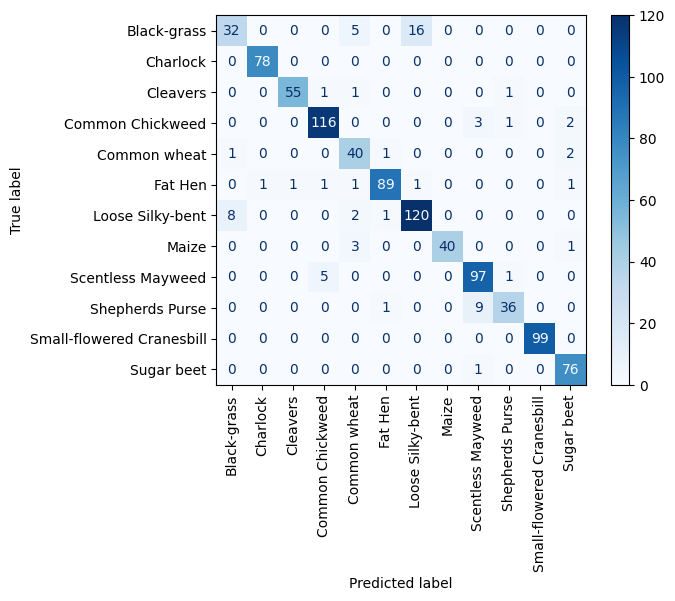

In [16]:
model.eval()

all_preds: List[int] = []
all_labels: List[int] = []
with torch.no_grad():
    for images, labels in val_loader:
        images: Tensor
        labels: Tensor
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(include_values=True, cmap="Blues", ax=None, xticks_rotation="vertical")
plt.show()

## Visualize Model


In [20]:
model.eval()

# Example input tensor
dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

# Visualize the model graph
output = model(dummy_input)
make_dot(output, params=dict(model.named_parameters())).render(
    DATA_ROOT / "vit_graph",
    format="png",
)

model = model.to("cpu")
summary(model, input_size=(3, 224, 224))
model = model.to(DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

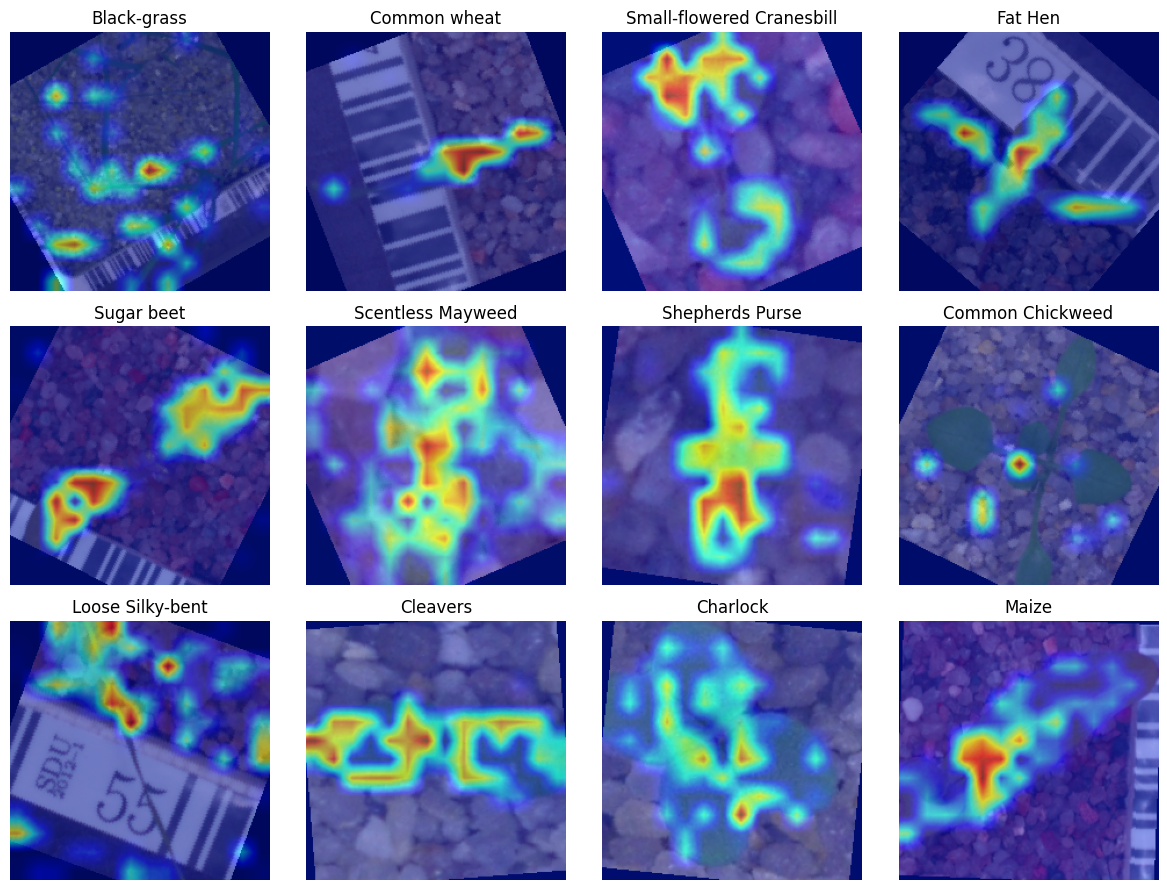

In [29]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


image: Tensor
label: int

model.eval()

target_layers: List[torch.nn.Module] = [model.blocks[-1].norm1]
for layer in target_layers:
    for param in layer.parameters():
        param.requires_grad = True

# Get one example per class
unique_examples = {}
for idx in range(len(train_loader.dataset)):
    image, label = train_loader.dataset[idx]
    if label not in unique_examples:
        unique_examples[label] = image

    if len(unique_examples) == num_classes:
        break

# Visualize Grad-CAM
visualizations = []
for label, image in unique_examples.items():
    targets = [ClassifierOutputTarget(label)]
    rgb_img = image.permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    rgb_img = np.float32(rgb_img)

    with GradCAM(
        model=model, target_layers=target_layers, reshape_transform=reshape_transform
    ) as cam:
        grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        visualizations.append((visualization, label))

# Plot
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for ax, (vis, label) in zip(axes.flatten(), visualizations):
    ax.imshow(vis)
    ax.set_title(dataset.classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

for layer in target_layers:
    for param in layer.parameters():
        param.requires_grad = False

## Submission


In [21]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in listdir(root_dir) if f.endswith(".png")]
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Tuple[Tensor, str]:
        img_path = path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]


transform = transforms.Compose(
    [
        transforms.Resize(transform_resize),
        transforms.ToTensor(),
        transforms.Normalize(mean=transform_mean, std=transform_std),
    ]
)

test_dataset = TestDataset(root_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

print(f"Test dataset length: {len(test_dataset)}")

Test dataset length: 794


In [22]:
predictions = []
with torch.no_grad():
    for images, image_names in test_loader:
        images: Tensor
        image_names: List[str]

        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for image_name, pred in zip(image_names, preds):
            predictions.append(
                {"file": image_name, "species": dataset.classes[pred.item()]}
            )

submission_file = (
    DATA_ROOT / f"submission-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(submission_file, index=False)

print(f"Predictions saved to '{submission_file}':")
print(predictions_df.head())

Predictions saved to 'data/submission-2024-12-29_17-22-42.csv':
            file           species
0  1b490196c.png   Shepherds Purse
1  85431c075.png  Loose Silky-bent
2  506347cfe.png          Cleavers
3  7f46a71db.png        Sugar beet
4  668c1007c.png          Charlock
